In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import calendar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
path = (r"C:\Users\namit\OneDrive\Desktop\upwork projects\upwork_task_1.csv")
df = pd.read_csv(path)
data = df['Y']
df.head()

,UNIQUE_ID,Y,DS
0,9999_990090,0.0,2023-01-01
1,9999_990091,0.0,2023-01-01
2,9999_990093,0.0,2023-01-01
3,9999_990094,0.0,2023-01-01
4,9999_990212,0.0,2023-01-01


In [3]:
df.dtypes

UNIQUE_ID     object
Y            float64
DS            object
dtype: object

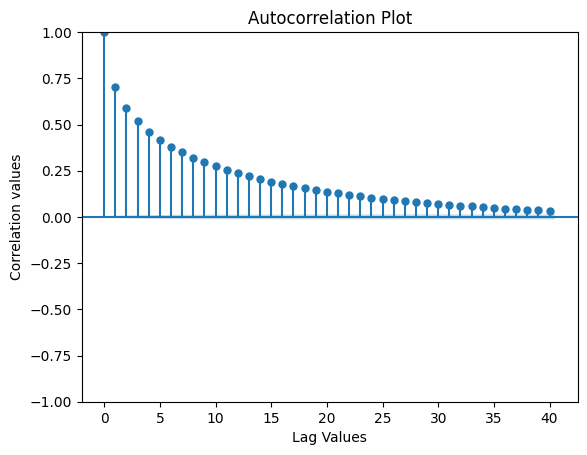

In [4]:
plot_acf(data, lags=40, alpha=0.05, use_vlines=True, title='Autocorrelation Plot', zero=True)
plt.ylabel('Correlation values')
plt.xlabel('Lag Values')
plt.show()
#q = 40

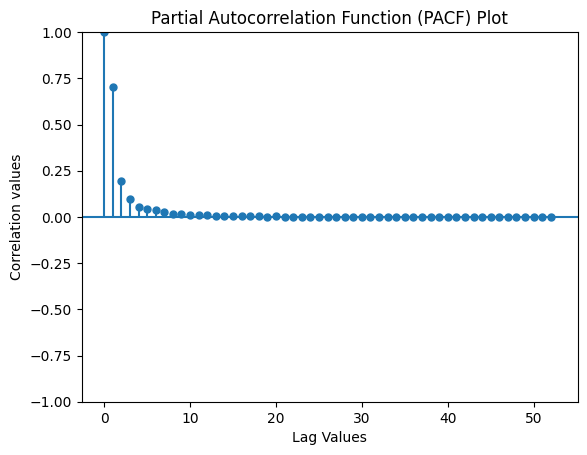

In [8]:
# Plot PACF to further refine p
plot_pacf(data)
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.ylabel('Correlation values')
plt.xlabel('Lag Values')
plt.show()
#q = 1

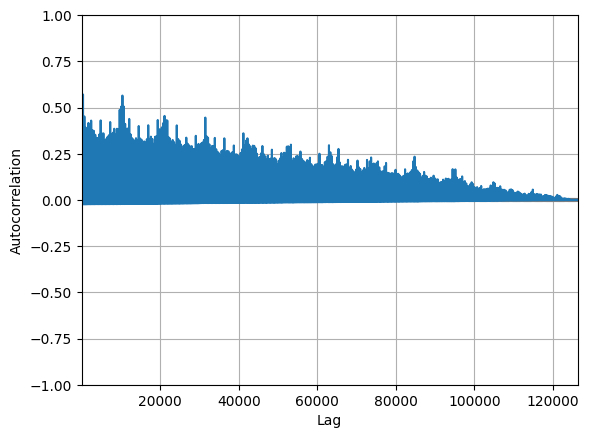

In [5]:
autocorrelation_plot(data)
plt.show()

In [6]:
result = adfuller(data)

In [7]:
result

(-57.50633347148043,
 0.0,
 16,
 126273,
 {'1%': -3.4304017880539717,
  '5%': -2.8615628895609757,
  '10%': -2.5667821833032036},
 1538148.306928714)

In [9]:
result = adfuller(data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
# Check if stationary based on p-value
if result[1] < 0.05:
    print('Reject null hypothesis - Time series is stationary')
else:
    print('Fail to reject null hypothesis - Time series is non-stationary')

# Determine suitable value for d
d = 0
while result[1] >= 0.05:
    d += 1
    differenced_data = data.diff().dropna()
    result = adfuller(differenced_data)
    print(f'ADF Statistic with d={d}:', result[0])
    print(f'p-value with d={d}:', result[1])

print(f'Suitable value for d is {d}')
# d = 0

ADF Statistic: -57.50633347148043
p-value: 0.0
Reject null hypothesis - Time series is stationary
Suitable value for d is 0


In [17]:
df.head()

,Y
DS,
2023-01-01,0.00
2023-01-02,0.00
2023-01-03,3026.00
2023-01-04,4342.20
2023-01-05,3007.25


In [9]:
df['DS'] = pd.to_datetime(df['DS'], format='%Y-%m-%d')

In [10]:
df = df.sort_values('DS')

In [11]:
column= 'UNIQUE_ID'
df = df.drop(column, axis=1)

In [12]:
df.set_index('DS', inplace=True)

In [13]:
df = df.groupby(df.index).sum()

In [14]:
df = df.asfreq('D')

# ARIMA

- 1. Create data for ARIMA by adding datetime column "DS" which we did not include in the features for normalization.
- 2. Add DS to the normalized features dataframe
- 3. Set DS as the index
- 4. Check whether the data is stationary by ADF test
- 5. If found non stationary, apply differencing
- 6. Use autocorrelation (ACF) and partial autocorrelation (PACF) plots to determine the values of p (AR order) and q (MA order).
- 7. Determine d (order of differencing) based on the results from the stationarity check.

In [15]:
# Split data into train and test sets
train_data = df[:-10]  # Example: Use all but last 10 observations for training
test_data = df[-10:]   # Example: Use last 10 observations for testing

In [22]:
# Define the ARIMA model with the identified parameters
p = 7  # Example: AR term from ACF/PACF plots
d = 0  # Example: Differencing term from stationarity check (ADF test)
q = 1  # Example: MA term from ACF plot

In [23]:
# Fit the ARIMA model
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

In [24]:
# Print the model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  355
Model:                 ARIMA(7, 0, 1)   Log Likelihood               -3745.734
Date:                Tue, 25 Jun 2024   AIC                           7511.467
Time:                        12:44:25   BIC                           7550.189
Sample:                    01-01-2023   HQIC                          7526.872
                         - 12-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8067.6531    803.547     10.040      0.000    6492.730    9642.576
ar.L1         -0.2066      0.601     -0.344      0.731      -1.384       0.971
ar.L2          0.1556      0.184      0.845      0.3

In [21]:
# Model diagnostics
residuals = model_fit.resid

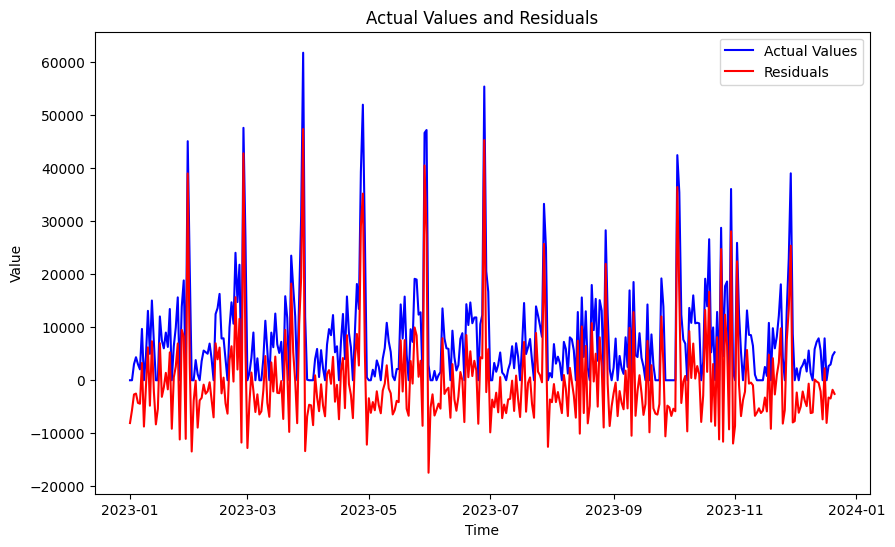

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Actual Values', color='blue')

# Overlay residuals plot
plt.plot(residuals, label='Residuals', color='red')

plt.title('Actual Values and Residuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

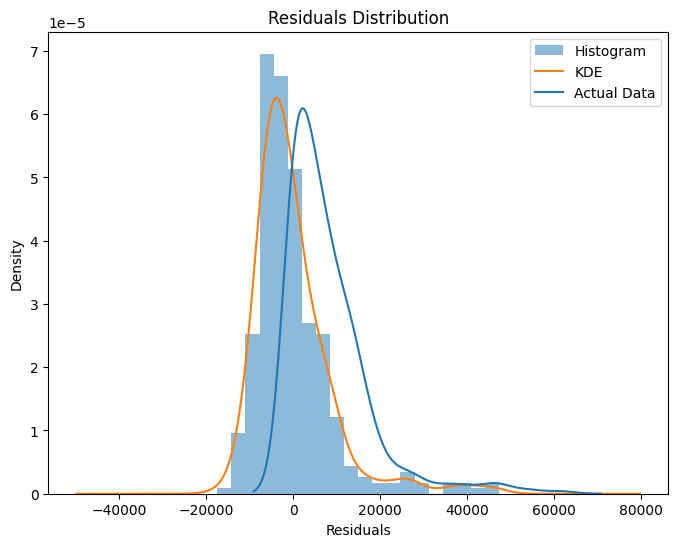

In [26]:
# Plot residuals histogram and KDE plot together
plt.figure(figsize=(8, 6))
residuals.plot(kind='hist', bins=20, density=True, alpha=0.5, label='Histogram')
residuals.plot(kind='kde', label='KDE')
sns.kdeplot(train_data, label='Actual Data', color='red')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()


In [27]:
# Forecasting
forecast = model_fit.forecast(steps=len(test_data))
forecast = pd.Series(forecast, index=test_data.index)

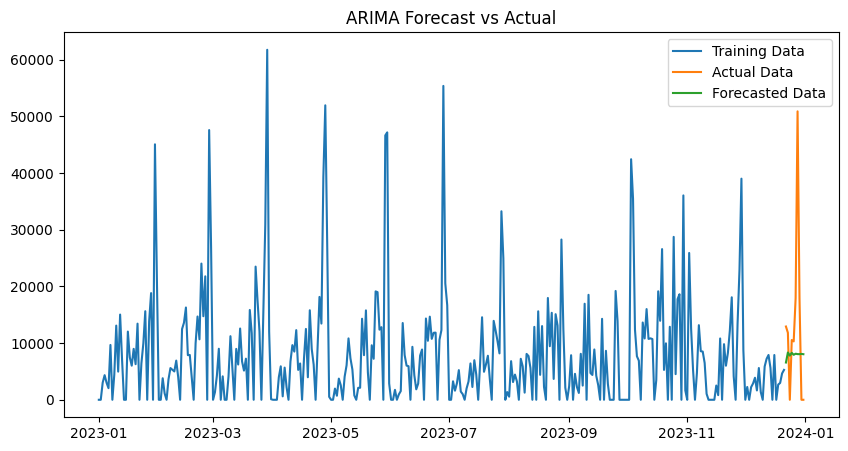

In [28]:
# Plot the forecast against the actual data
plt.figure(figsize=(10, 5))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Data')
plt.plot(forecast, label='Forecasted Data')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

In [29]:
# Compute forecast error metrics
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)

print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

NameError: name 'mean_squared_error' is not defined

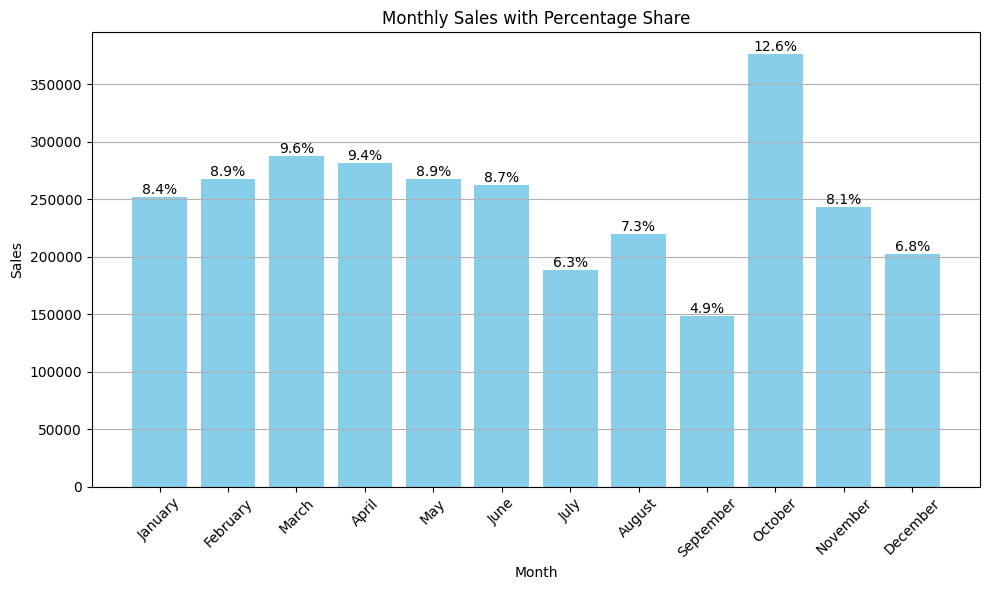

In [8]:
# Extract month for grouping
df['month'] = df['DS'].dt.month

# Aggregate sales by month
monthly_sales = df.groupby('month')['Y'].sum()

total_sales = monthly_sales.sum()

# Calculate percentage for each month
percentages = (monthly_sales / total_sales) * 100

month_names = [calendar.month_name[i] for i in range(1, 13)]  

plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, 13), monthly_sales, color='skyblue')

# Add percentage annotations
for bar, percent in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f'{percent:.1f}%', ha='center', va='bottom', fontsize=10)

plt.title('Monthly Sales with Percentage Share')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(range(1, 13), month_names, rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [9]:
df['day_of_week'] = df['DS'].dt.dayofweek


In [10]:
df.head()

,UNIQUE_ID,Y,DS,month,day_of_week
0,9999_990090,0.0,2023-01-01,1,6
235,9999_997072,0.0,2023-01-01,1,6
234,9999_997041,0.0,2023-01-01,1,6
233,9999_997015,0.0,2023-01-01,1,6
232,9999_997012,0.0,2023-01-01,1,6


In [63]:
df['day_of_week'].unique()

array([6, 0, 1, 2, 3, 4, 5], dtype=int64)

In [11]:
# Aggregate sales by month
monthly_data = df.groupby('month')['Y'].sum().reset_index()

# Aggregate sales by week
weekly_data = df.groupby('day_of_week')['Y'].sum().reset_index()


In [12]:
monthly_data.columns = ['month', 'monthly_sale']

In [13]:
weekly_data.columns = ['day_of_week', 'weekly_sale']

In [14]:
# Map monthly sales to the original data
df['monthly_sale'] = df['month'].map(monthly_data.set_index('month')['monthly_sale'])

# Map weekly sales to the original data
df['weekly_sale'] = df['day_of_week'].map(weekly_data.set_index('day_of_week')['weekly_sale'])

# Display the original data with new features
df.head()


,UNIQUE_ID,Y,DS,month,day_of_week,monthly_sale,weekly_sale
0,9999_990090,0.0,2023-01-01,1,6,252207.1,521.9
235,9999_997072,0.0,2023-01-01,1,6,252207.1,521.9
234,9999_997041,0.0,2023-01-01,1,6,252207.1,521.9
233,9999_997015,0.0,2023-01-01,1,6,252207.1,521.9
232,9999_997012,0.0,2023-01-01,1,6,252207.1,521.9


In [15]:
df.dtypes

UNIQUE_ID               object
Y                      float64
DS              datetime64[ns]
month                    int64
day_of_week              int64
monthly_sale           float64
weekly_sale            float64
dtype: object

In [16]:
df.head()

,UNIQUE_ID,Y,DS,month,day_of_week,monthly_sale,weekly_sale
0,9999_990090,0.0,2023-01-01,1,6,252207.1,521.9
235,9999_997072,0.0,2023-01-01,1,6,252207.1,521.9
234,9999_997041,0.0,2023-01-01,1,6,252207.1,521.9
233,9999_997015,0.0,2023-01-01,1,6,252207.1,521.9
232,9999_997012,0.0,2023-01-01,1,6,252207.1,521.9


<Axes: title={'center': 'Monthly Sales Box Plot'}, xlabel='monthly_sale'>

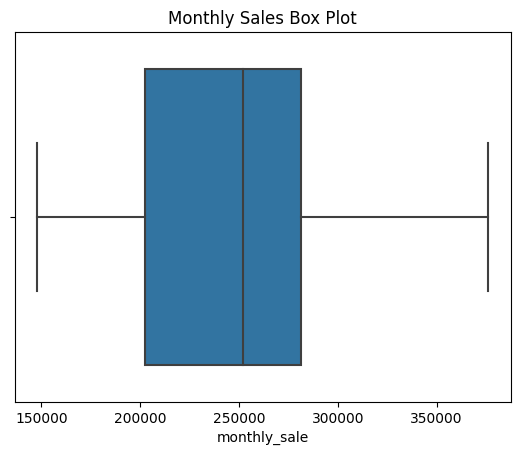

In [17]:
plt.title('Monthly Sales Box Plot')
sns.boxplot(x = df['monthly_sale'])

<Axes: title={'center': 'Weekly Sales Boxplot'}, xlabel='weekly_sale'>

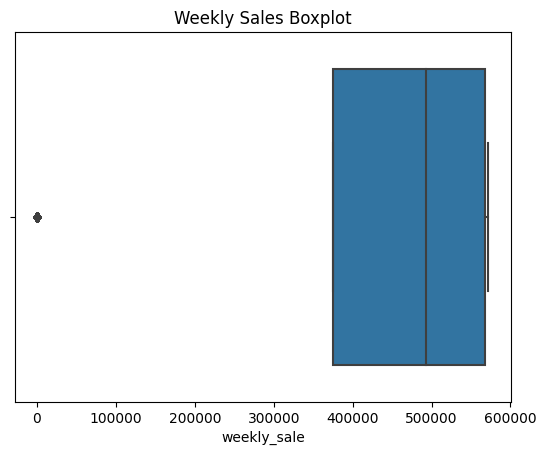

In [18]:
plt.title('Weekly Sales Boxplot')
sns.boxplot(x = df['weekly_sale'])

In [11]:
import pandas as pd

def check_negative_values(df):
    """
    Check for negative values in each column of a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to check.

    Returns:
    dict: A dictionary with column names as keys and booleans as values indicating
          the presence of negative values.
    """
    negative_values = {}
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # Check only numeric columns
            negative_values[col] = (df[col] < 0).any()
        else:
            negative_values[col] = False
    return negative_values


print(check_negative_values(df))


{'Y': False}


In [10]:
def check_negative_and_zero_values(df):
    negative_counts = {}
    zero_counts = {}
    
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            negative_counts[column] = (df[column] < 0).sum()
            zero_counts[column] = (df[column] == 0).sum()
    
    return negative_counts, zero_counts

# Get counts of negative and zero values for each column
negative_counts, zero_counts = check_negative_and_zero_values(df)

print("Negative values count per column:\n", negative_counts)
print("Zero values count per column:\n", zero_counts)


Negative values count per column:
 {'Y': 0}
Zero values count per column:
 {'Y': 86}


In [26]:
X = df[[ 'month', 'day_of_week', 'monthly_sale',
       'weekly_sale']]
y = df['Y']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = MinMaxScaler()

In [72]:
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [73]:
# Display the transformed training data
print("Scaled Training Data:\n", X_train_scaled[:5])

# Display the transformed test data
print("Scaled Test Data:\n", X_test_scaled[:5])

Scaled Training Data:
 [[0.63636364 0.5        0.31406422 0.86185667]
 [0.18181818 0.5        0.61101484 0.86185667]
 [0.09090909 1.         0.52517122 0.        ]
 [0.63636364 0.         0.31406422 1.        ]
 [0.72727273 0.         0.         1.        ]]
Scaled Test Data:
 [[0.45454545 0.66666667 0.49959594 0.81656745]
 [0.90909091 0.33333333 0.41644798 0.9933573 ]
 [0.81818182 0.83333333 1.         0.65492117]
 [0.72727273 0.5        0.         0.86185667]
 [0.27272727 1.         0.58560214 0.        ]]


In [74]:
df2 = df

In [83]:
df2.head()

,Y,month,day_of_week,monthly_sale,weekly_sale
0,0.0,1,6,252207.1,521.9
235,0.0,1,6,252207.1,521.9
234,0.0,1,6,252207.1,521.9
233,0.0,1,6,252207.1,521.9
232,0.0,1,6,252207.1,521.9


In [82]:
df2.drop('DS', axis=1, inplace=True)

In [84]:
df2 = scaler.fit_transform(df2)

In [85]:
df2['year'] = df['DS']

KeyError: 'DS'

In [41]:
arima_data['year'] = pd.to_datetime(arima_data['year'])
arima_data.set_index('year', inplace=True)

In [48]:
arima_data['y'] = df['Y']

In [49]:
arima_data.head()

,month,day_of_week,monthly_sale,weekly_sale,y
year,,,,,
2023-01-01,0.636364,0.5,0.314064,0.861857,NaN
2023-01-01,0.181818,0.5,0.611015,0.861857,NaN
2023-01-01,0.090909,1.0,0.525171,0.000000,NaN
2023-01-01,0.636364,0.0,0.314064,1.000000,NaN
2023-01-01,0.727273,0.0,0.000000,1.000000,NaN


In [ ]:
# Check for stationarity using the Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')
        
adf_test(df['sale'])